In [2]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import imageio
import glob
import ntpath
import time
import os

from skimage.transform import resize
from concurrent.futures import ThreadPoolExecutor
executor = ThreadPoolExecutor(max_workers=16)
futures = []
%matplotlib inline

In [3]:
print(cv2.__version__)

4.1.2


In [4]:
image_path = 'D:/00_NCSU/Fall2020/ECE633_IndividualTopics/OAK-D-Weed-Cam/Model/Images/'

In [5]:
image = cv2.imread(image_path+'color1.png')
image2 = cv2.imread(image_path+'color.png')

In [6]:
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

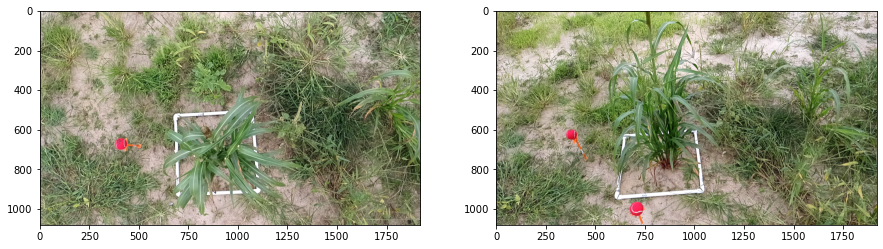

In [7]:
def plot_images(image, image2):
    fig, ax = plt.subplots(1,2, figsize=(15,15))
    ax[0].imshow(image)
    ax[1].imshow(image2)
plot_images(image, image2)

In [10]:
def apply_filter(image):
    """
    Define a 5X5 kernel and apply the filter to gray scale image
    Args:
        image: np.array
    Returns:
        filtered: np.array
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = np.ones((5, 5), np.float32) / 15
    filtered = cv2.filter2D(gray, -1, kernel)
    plt.imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
    plt.title('Filtered Image')
    plt.show()
    return filtered

In [8]:
def apply_threshold(filtered):
    """
    Apply OTSU threshold
    Args:
        filtered: np.array
    Returns:
        thresh: np.array
    """
    ret, thresh = cv2.threshold(filtered, 254, 255, cv2.THRESH_OTSU)
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    plt.title('After applying OTSU threshold')
    plt.show()
    return thresh
def detect_white(image):
    hsv=cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # define range of white color in HSV
    # change it according to your need !
    lower_white = np.array([0,0,0], dtype=np.uint8)
    upper_white = np.array([0,0,255], dtype=np.uint8)

    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(image,image, mask= mask)

#     plt.imshow('input',image)
    return mask, res

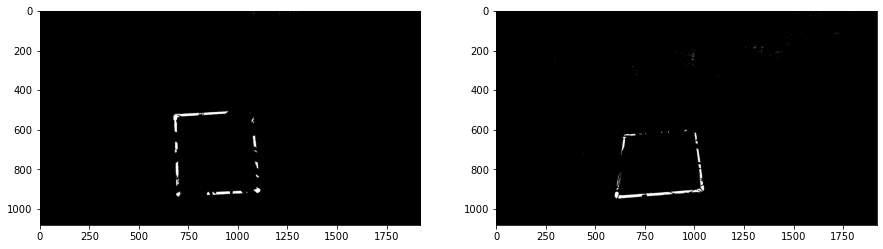

In [9]:
# filtered_image = apply_filter(image)
mas,res=detect_white(image)
mas2,res2=detect_white(image2)
plot_images(res,res2)
# threshold_image = apply_threshold(filtered_image)

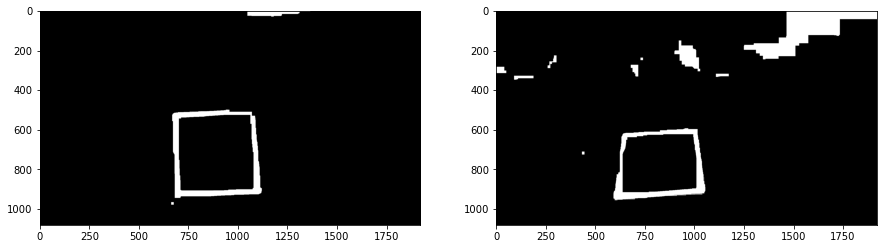

In [10]:
def complete_rec(rect):
    kernel = np.ones((5,5),np.uint8)
    dilation= cv2.dilate(rect, kernel, iterations = 35)
    closing = cv2.erode(dilation,kernel,iterations =32)
#     closed = cv2.morphologyEx(rect,cv2.MORPH_HITMISS, kernel)
    return closing
closing = complete_rec(res)
closing2 = complete_rec(res2)

plot_images(closing, closing2)

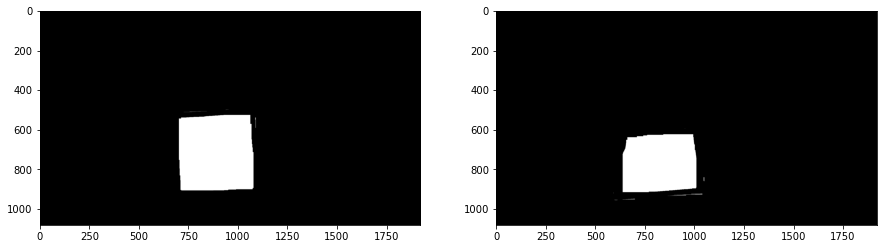

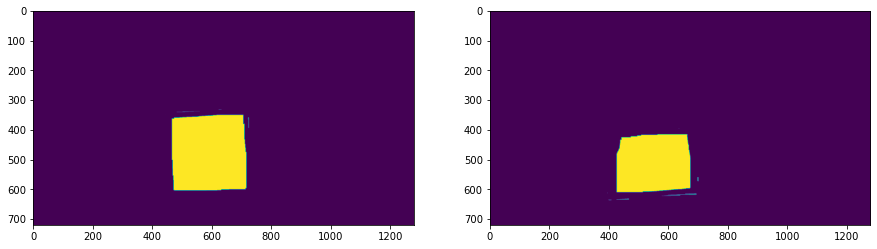

In [11]:
def floodFill(im_in):
#     _, im_in_th = cv2.threshold(im_in, 250, 255, cv2.THRESH_BINARY_INV)
#     im_bw = cv2.cvtColor(im_in, cv2.COLOR_RGB2GRAY)
#     (thresh, im_bw) = cv2.threshold(im_bw, 250, 255, 0)
#     contours, hierarchy = cv2.findContours(im_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     print(contours)
#     img_bin = np.zeros((im_in.shape[0], im_in.shape[1],3), np.uint8)
#     cv2.drawContours(img_bin, contours, -1, (255, 255, 255), -1)
#     img_bin = cv2.fillPoly(img_bin, contours, (255,255,255))
#     th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);
    im_floodfill = im_in.copy()
    h, w = im_in.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), (255,255,255));

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_in | im_floodfill_inv
    
    return im_floodfill, im_floodfill_inv, im_out

_, im_floodfill_inv, _ = floodFill(closing)
_, im_floodfill_inv2, _ = floodFill(closing2)
plot_images(im_floodfill_inv,im_floodfill_inv2)

depth1=np.load(image_path+'depth.npy')
depth1.shape
depth2=np.load(image_path+'depth2.npy')
depth2.shape
mask1, mask2 = cv2.resize(cv2.cvtColor(im_floodfill_inv, cv2.COLOR_RGB2GRAY), (1280, 720)),  cv2.resize(cv2.cvtColor(im_floodfill_inv2, cv2.COLOR_RGB2GRAY), (1280,720))
plot_images(mask1,mask2)


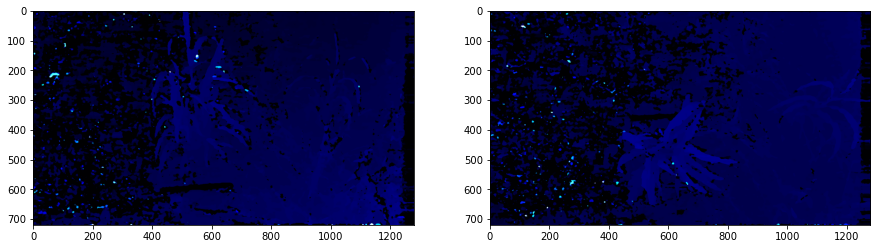

In [12]:
def vis_depth(depth1, depth2):
    depth1=(65535//depth1).astype(np.uint8)
    depth1 = cv2.applyColorMap(depth1, cv2.COLORMAP_HOT)
    depth2=(65535//depth2).astype(np.uint8)
    depth2 = cv2.applyColorMap(depth2, cv2.COLORMAP_HOT)
    plot_images(depth1, depth2)
#     return depth1, depth2
vis_depth(depth1, depth2)


C:\Users\sarde\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in floor_divide
  
C:\Users\sarde\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in floor_divide
  after removing the cwd from sys.path.


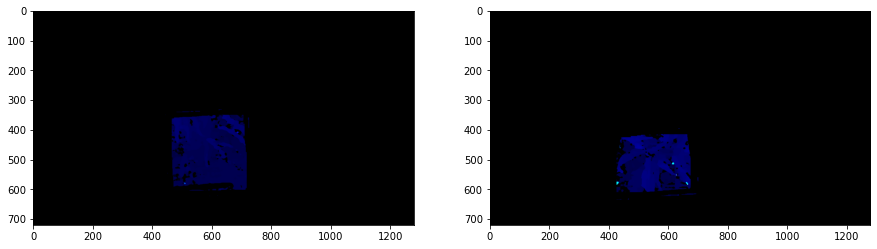

In [13]:
depth_roi, depth_roi2=cv2.bitwise_and(depth1, depth1, mask=mask1), cv2.bitwise_and(depth2,depth2,mask= mask2)
depth_roi.dtype
vis_depth(depth_roi, depth_roi2)

In [21]:
print(depth_roi.min(), depth_roi.max(), depth_roi2.min(), depth_roi2.max(), sep=' ')

0 65535 0 65535


In [31]:
current_input_size = 513
current_model = "3_class_model_mobilenet_v3_small_v1.0/3_class_model_mobilenet_v3_small_v1.0_513x513.pb"

class DeepLabModel():
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    SOFTMAX_TENSOR_NAME = 'SemanticProbabilities:0'
    INPUT_SIZE = current_input_size


    def __init__(self, path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.

        with tf.gfile.GFile(path, 'rb')as file_handle:
            graph_def = tf.GraphDef.FromString(file_handle.read())

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        
        # To Run on CPU, uncomment below and add config to self.session as: ", config=config"
        config = tf.ConfigProto(
            device_count = {'GPU': 0}
            )

        self.sess = tf.Session(graph=self.graph, config=config)


    def run(self, image):
        """Runs inference on a single image.

        Args:
          image: A PIL.Image object, raw input image.

        Returns:
          seg_map: np.array. values of pixels are classes
        """

        width, height,ch = image.shape

        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))

        resized_image = cv2.resize(image, (target_size))

        batch_seg_map, batch_prob_map = self.sess.run(
           [self.OUTPUT_TENSOR_NAME,
           self.SOFTMAX_TENSOR_NAME],
           feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(image)]})

        seg_map = batch_seg_map[0]        
        # seg_map = resize(seg_map.astype(np.uint8), (height, width), preserve_range=True, order=0, anti_aliasing=False)
        prob_map = batch_prob_map[0]        
        return seg_map, prob_map

In [57]:
(depth1.shape[0],depth1.shape[1],3)
(seg_map1.shape[0],seg_map1.shape[1],3)
prob_map1.dtype


dtype('float32')

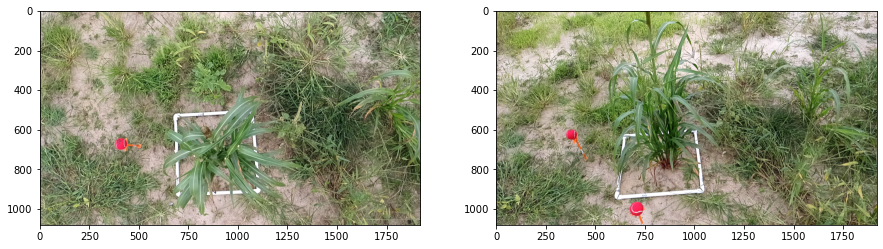

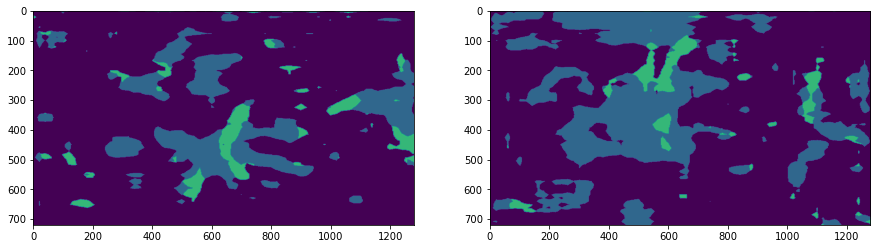

In [63]:
model = DeepLabModel("D:/00_NCSU/Fall2020/ECE633_IndividualTopics/OAK-D-Weed-Cam/Model/deeplabv3+/models/" + current_model)
model_image_input1 = cv2.resize(image, (current_input_size, current_input_size))
# model_image_input1=image
seg_map1, prob_map1=model.run(model_image_input1)
# model_image_input2=image2
model_image_input2 = cv2.resize(image2, (current_input_size, current_input_size))
seg_map2, prob_map2=model.run(model_image_input2)

seg_map1r=cv2.resize(seg_map1.astype(np.uint8),(depth1.shape[1],depth1.shape[0]), interpolation = cv2.INTER_LANCZOS4)
seg_map2r=cv2.resize(seg_map2.astype(np.uint8),(depth2.shape[1],depth2.shape[0]), interpolation = cv2.INTER_LANCZOS4)
# prob_map1r=cv2.resize(prob_map1,(depth1.shape[0],depth1.shape[1], 3), interpolation = cv2.INTER_LANCZOS4)
# prob_map2r=cv2.resize(prob_map2,(depth2.shape[0],depth2.shape[1], 3), interpolation = cv2.INTER_LANCZOS4)
plot_images(image, image2)
plot_images(seg_map1r, seg_map2r)

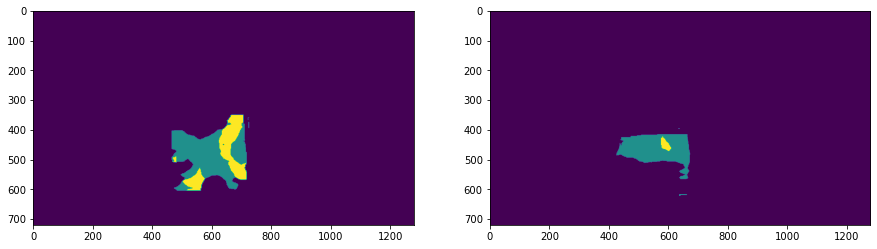

In [65]:
mask_seg1, mask_seg2=cv2.bitwise_and(seg_map1r, seg_map1r, mask=mask1), cv2.bitwise_and(seg_map2r,seg_map2r,mask= mask2)
plot_images(mask_seg1, mask_seg2)

In [67]:
np.count_nonzero(mask_seg1), np.count_nonzero(mask1)

(41574, 61792)

In [82]:
area1 = np.count_nonzero(mask_seg1)/np.count_nonzero(mask1)*0.25
area2 = np.count_nonzero(mask_seg2)/np.count_nonzero(mask2)*0.25
area1
np.where(mask_seg1!=0)[0]

array([351, 351, 351, ..., 604, 604, 604], dtype=int64)

In [84]:
def calc_volume(mask_seg1, area1, depth_roi):
    vol=0
    non_zeros=np.where(mask_seg1!=0)
    for i,j in zip(non_zeros[0], non_zeros[1]):
        vol+=(depth_roi[i][j]*0.001/np.count_nonzero(mask_seg1))*area1
    return vol

%timeit v1=calc_volume(mask_seg1, area1, depth_roi)
%timeit v2=calc_volume(mask_seg2, area2, depth_roi)

v1
v2

58.4 s ± 1.63 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
29.3 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NameError: name 'v1' is not defined

In [85]:
v1 = calc_volume(mask_seg1, area1, depth_roi)
v2 = calc_volume(mask_seg2, area2, depth_roi2)

In [87]:
v1

1.4323709258473185

In [88]:
v2

0.9144270691260263

In [ ]:
import seaborn as sns

sns.distplot(depth1_roi)